<font size="5">Cython</font> <font size="3">is a programming language to write C extensions for Python language.

- The allows static type declarations of varaiables, scalars and mulitdimensional vectors.
- The source gets translated into optimized C/C++ code and compiled as Python extension module.
- The module can then be called in a Python script.
- External performant libraries written in C/C++ can be linked to the these extensions. 

- Static typing is usually the major source of performance imporvment over the dynamically typed Python variables.
- Also, when static typing is used, it is easy to pass these variable to the external non-pythonic libraries when linking.
    
    
- Cython is a convineient way of temporarily releasing Global Interpreter Lock by handing over control of compute bound parts of code to the C object and accelerate it with libraries which are traditionally used to implement multithreading.
</font>

For demonstration, let us approximate area under a curve using Simpon method of integration.

- Assume we have smooth continous function over a finite interval [0,1]

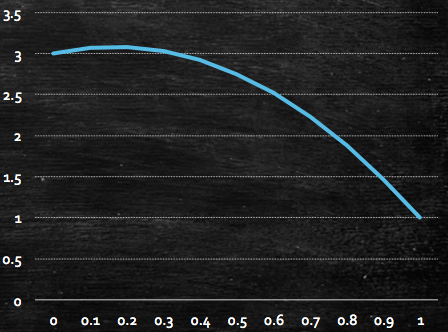

- We want to evalute its integral over the interval <font size ="3"> $\int_0^1 f(x) dx$ </font>


- <font size="5"> Numerically </font> it can be approximated as  <font size ="5"> $\int_0^1 f(x) dx \approx \sum_{i=1}^N = a_i$ </font>
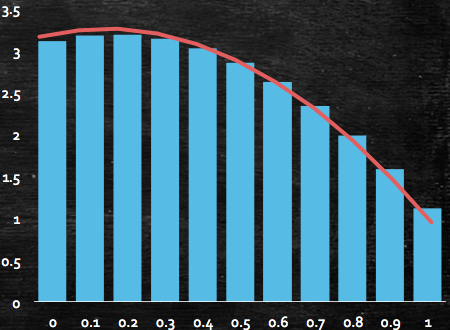

- Area under the curve is approximated as of the areas of all the rectangles.

# Serail version

In [1]:
import numpy as np

Let's define our $f(x)$

In [2]:
def f(x):
    return (3.0 + x - 3.0*x*x)

In [3]:
# Since the interval was from 0 to 1
x1=0.0
x2=1.0

# Let's create a 1D domain. dx is the space between each point.  
dx=1e-7
points = np.arange(x1+dx,x2+dx,dx)

In [4]:
%%timeit -n1 -r1 
area=0.0
for x in points:
    area += dx * f(x)
print("Approximate area under the curve ",area)

Approximate area under the curve  2.4999999000001543
8.05 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Paralell version (Cython with OpenMP)

- More rectanlges lead to better approximation. But this comes at the cost of more computation.
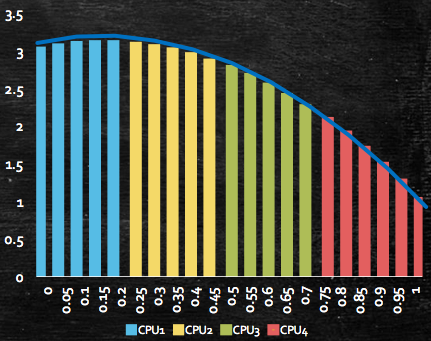
- We can distribute the computation to multiple cores running a thread per core to compute partial sums.
- Once done, we can add the partial sums to get the final area.

In [5]:
# Need for Jupyter notebook environment 
import cython
%load_ext Cython

- Following is a Cythonized function called  <b>integrate</b>. 
- The top line <b>%%cython</b> is the command line which runs to compile a C object. The compiler and linker flag  <b>-fopenmp</b> expose the OpenMP directive to implement multithreading using OpenMP library which is a part of the GNU compiler.
- <b>--annotate</b> annotates the C compiled code for the level of optimization forced on it. 
- <b>cython.parallel.prange</b> is used to automatically parallelise a for loop using OpenMP.
- <b>N</b> here is the total number of interations and <b>schedule</b> controls the distribution of the itereations to the OpenMP threads.

In [6]:
%%cython --compile-args=-fopenmp --compile-args=-O3 --link-args=-fopenmp --force --annotate
cimport cython
from cython.parallel import parallel, prange
from libc.stdlib cimport malloc

cimport numpy as np
@cython.boundscheck(False)
@cython.wraparound(False)
def integrate( double [:] x, double dx ):
    # we define some local variable using C types
    cdef int i, N
    cdef double integral_val = 0.0

  # Let's allocate a temporary array that holds the area values of all of the rectangles inside our
  # integration domain (eg. [x1,x2])
    N = x.shape[0]
    cdef double *areas = <double *>malloc( N*sizeof(double) )
    if not areas:
       raise MemoryError()

  # We spawn 4 OpenMP threads that compute the individual rectanglar areas in parallel.  Notice that
  # we no longer use a seperate f function anymore
#    try:
    with nogil, parallel(num_threads=4):
            for i in prange( N, schedule='static' ):
                areas[i] = dx * (3.0 + x[i] - 3.0*x[i]*x[i])
                
  # Finally, we sum up all the individual rectangular areas to get out final integral value. No 
  # locking or sychronization required as the addition is associative and ordering is not important.
            for i in prange( N, schedule='static' ):
                integral_val += areas[i]

    return integral_val

We can now call the function <b>integrate</b> to evalute with 4 OpenMP threads.

In [7]:
import numpy as np

## Now let's the interval over which we will integrate

x1 = 0.0
x2 = 1.0
    
## Define the width of each of the rectangles we use to determine the area.  Remember
## that the smaller the width, the more accurate our solution will be -but the time
## to solution will increase.

dx = 1e-7
points = np.arange( x1+dx, x2+dx, dx )

In [8]:
%%timeit -n1 -r1 
computed_soln = integrate( points, dx )
print("Approximate area under the curve ",computed_soln)

Approximate area under the curve  2.4999999000001623
29.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
